## Classify pictures of cats and dogs
- This notebook is an example of a **overfitting problem** which is encounter while training the model. 
- Demostration of accuracy on both training and validatin example with number of epochs.

### Importing packages

In [1]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np


In [0]:
import logging
logger =tf.get_logger()
logger.setLevel(logging.ERROR)

### Loading the data

1. We will directly read the data from the url. Data used here is provided by Microsoft Research.

In [5]:
_Link = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
_Dir= tf.keras.utils.get_file('cats_and_dogs_filtered.zip',origin=_Link,extract=True)

68608000/68606236 [==============================] - 0s 0us/step


2. Lisitng the directories using the terminal commands

In [6]:
_Dir_base = os.path.dirname(_Dir)
!find $_Dir_base -type d -print



/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats


In [0]:
base_Dir =os.path.join(os.path.dirname(_Dir), 'cats_and_dogs_filtered')
train_Dir = os.path.join(base_Dir,'train')
validation_Dir = os.path.join(base_Dir,'validation')

train_cats_dir = os.path.join(train_Dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_Dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_Dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_Dir, 'dogs')  # directory with our validation dog pictures


In [8]:
## Number of cats and dogs in training set 
num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))

## Number of cats and dogs in validation set
num_cats_vd = len(os.listdir(validation_dogs_dir))
num_dogs_vd = len(os.listdir(validation_dogs_dir))

## Total training example 
totalTrain = num_cats_train + num_dogs_train
## Total validation example
totalValidation = num_cats_vd + num_dogs_vd

print('total training cat images:', num_cats_train)
print('total training dog images:', num_dogs_train)

print('total validation cat images:', num_cats_vd)
print('total validation dog images:', num_dogs_vd)
print("--")
print("Total training images:", totalTrain)
print("Total validation images:", totalValidation)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


### Data modeling 

#### Data preparation
1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

In [0]:
BATCH_SIZE = 100 # No. of traning examples to process before updating the model variables
IMG_SIZE = 150 # image width 150 and height 150 pixels

train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [13]:
# flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code.
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_Dir,
                                                           target_size=(IMG_SIZE,IMG_SIZE), #(150,150)
                                                           shuffle= True,
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory= validation_Dir,
                                                              target_size= (IMG_SIZE,IMG_SIZE), #(150,150)
                                                              shuffle= False,
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Visualising training Images 
Done by getting a batch of images from the training generator, and then ploting a few of them.

In [0]:
sample_training_images, _ = next(train_data_gen) ## next function returns a batch of images.

One batch is a tuple of (many images, many labels). For right now, we're discarding the labels because we just want to look at the images.

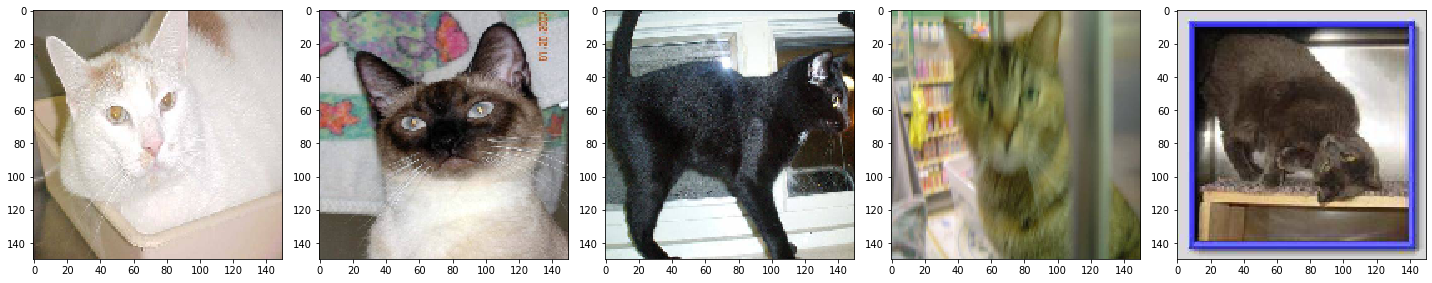

In [21]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])  # Plot images 0-4

## Creating a model
### Defining a model
- The model will have 4 Convolutional layers with a max pool layer in each of them.
- Then we will have a fully connected layer with 512 units, with a `relu` activation function
- The model will outputs the 2 class as probabilites for two cats and dogs from the `softmax` layer

In [0]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3), activation= 'relu', input_shape=(150,150,3)),
                                    tf.keras.layers.MaxPool2D(2,2),

                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(2, activation='softmax')

                                    ])

### Compiling the model

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Training the model

In [29]:
%%time
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch= int(np.ceil(totalTrain / float(BATCH_SIZE))),
    epochs= EPOCHS,
    validation_data = val_data_gen,
    validation_steps= int(np.ceil(totalValidation/ float(BATCH_SIZE)))
)

Train for 20 steps, validate for 10 steps
Epoch 1/100
20/20 [==============================] - 14s 679ms/step - loss: 0.7745 - accuracy: 0.4910 - val_loss: 0.6917 - val_accuracy: 0.5170
Epoch 2/100
20/20 [==============================] - 7s 374ms/step - loss: 0.6920 - accuracy: 0.5300 - val_loss: 0.6907 - val_accuracy: 0.5120
Epoch 3/100
20/20 [==============================] - 8s 376ms/step - loss: 0.6828 - accuracy: 0.5735 - val_loss: 0.6628 - val_accuracy: 0.6430
Epoch 4/100
20/20 [==============================] - 7s 373ms/step - loss: 0.6280 - accuracy: 0.6705 - val_loss: 0.6539 - val_accuracy: 0.6480
Epoch 5/100
20/20 [==============================] - 8s 377ms/step - loss: 0.6045 - accuracy: 0.6775 - val_loss: 0.6028 - val_accuracy: 0.6710
Epoch 6/100
20/20 [==============================] - 7s 375ms/step - loss: 0.5687 - accuracy: 0.7005 - val_loss: 0.5690 - val_accuracy: 0.7100
Epoch 7/100
20/20 [==============================] - 7s 369ms/step - loss: 0.5067 - accuracy: 0.752

## Visaulizing the results of the training 

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)



<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

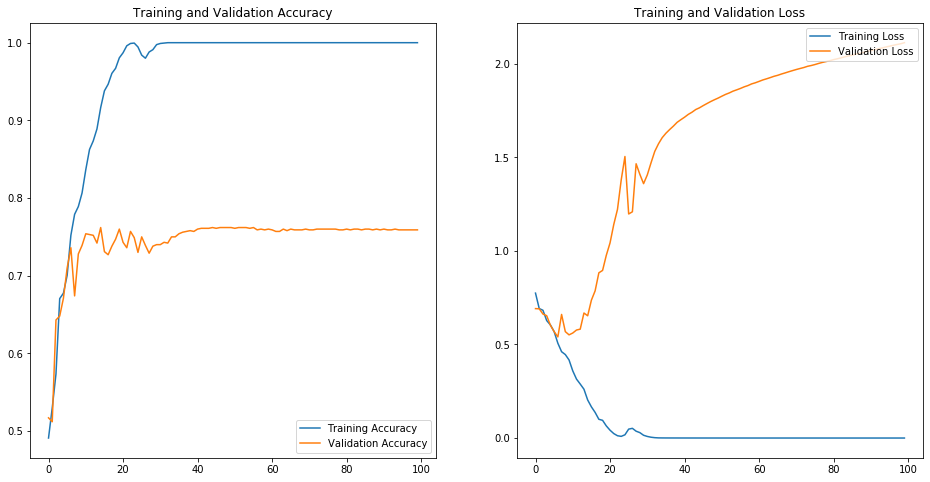

In [35]:
plt.figure(figsize=(16, 8))
# figure 1 Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# figure 2 Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

There is a huge difference in training and validation accuracy. 
Validation accuracy is only 70% on validation set.

Thus this shows **overfitting**. Once the training and validation curves starts to diverge, our model has started to memorize the training data and is unable to perform well on the validation set.